In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/best_model_epoch_3/adapter_model.safetensors
/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/best_model_epoch_3/adapter_config.json
/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/best_model_epoch_3/README.md
/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/best_model_epoch_1/adapter_model.safetensors
/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/best_model_epoch_1/adapter_config.json
/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/best_model_epoch_1/README.md
/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/checkpoint_epoch_1/adapter_model.safetensors
/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/checkpoint_epoch_1/adapter_config.json
/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/checkpoint_epoch_1/README.md
/kaggle/input/latest-lora_vqa/p

In [2]:
# Install necessary packages
!pip install gdown -q
!pip install pandas matplotlib seaborn -q
# Install necessary packages for BLIP model and LoRA fine-tuning
!pip install transformers peft accelerate bitsandbytes -q
!pip install torch torchvision pillow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00:00:0100:01


In [3]:
# Import libraries
import os
import json
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering
from PIL import Image
import gc
from pathlib import Path
from peft import get_peft_model, LoraConfig, TaskType
import inspect
import shutil

2025-05-17 21:55:53.009381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747518953.202409      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747518953.256434      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Download the zip file from Google Drive using gdown
!gdown --id 1UckUvFh3H1GJ2h_nUXDopaCNsHsGxW1k

# Create a data directory if it doesn't exist
!mkdir -p vqa_data

# Extract the zip file into the data directory
with zipfile.ZipFile('dataset-batches.zip', 'r') as zip_ref:
    zip_ref.extractall('vqa_data')
    
print("Dataset downloaded and extracted successfully!")

# List the contents of the extracted directory
!ls -la vqa_data

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1UckUvFh3H1GJ2h_nUXDopaCNsHsGxW1k
From (redirected): https://drive.google.com/uc?id=1UckUvFh3H1GJ2h_nUXDopaCNsHsGxW1k&confirm=t&uuid=2ba555e4-3d59-4089-9670-530c684b3349
To: /kaggle/working/dataset-batches.zip
100%|████████████████████████████████████████| 144M/144M [00:02<00:00, 49.5MB/s]
Dataset downloaded and extracted successfully!
total 12
drwxr-xr-x 3 root root 4096 May 17 21:56 .
drwxr-xr-x 4 root root 4096 May 17 21:56 ..
drwxr-xr-x 6 root root 4096 May 17 21:56 dataset-batches


In [5]:
# Define base path
base_path = 'vqa_data/dataset-batches/'

# Get list of all batches
batch_folders = [f for f in os.listdir(base_path) if f.startswith('batch') and os.path.isdir(os.path.join(base_path, f))]
metadata_files = [f for f in os.listdir(base_path) if f.endswith('_metadata.json')]
qa_dataset_files = [f for f in os.listdir(base_path) if f.endswith('_qa_dataset.json')]

print(f"Found {len(batch_folders)} batch folders: {sorted(batch_folders)}")
print(f"Found {len(metadata_files)} metadata files: {sorted(metadata_files)}")
print(f"Found {len(qa_dataset_files)} QA dataset files: {sorted(qa_dataset_files)}")

# Count images in each batch directory
for batch in sorted(batch_folders):
    batch_path = os.path.join(base_path, batch)
    n_images = len(os.listdir(batch_path))
    print(f"{batch}: {n_images} images")

Found 4 batch folders: ['batch1', 'batch2', 'batch3', 'batch4']
Found 4 metadata files: ['batch1_metadata.json', 'batch2_metadata.json', 'batch3_metadata.json', 'batch4_metadata.json']
Found 4 QA dataset files: ['batch1_qa_dataset.json', 'batch2_qa_dataset.json', 'batch3_qa_dataset.json', 'batch4_qa_dataset.json']
batch1: 5078 images
batch2: 4885 images
batch3: 4753 images
batch4: 4639 images


In [6]:
# Load all QA dataset files
qa_data = {}
for qa_file in tqdm(sorted([f for f in os.listdir(base_path) if f.endswith('_qa_dataset.json')]), 
                    desc="Loading QA dataset files"):
    with open(os.path.join(base_path, qa_file), 'r', encoding='utf-8') as f:
        batch_name = qa_file.split('_')[0]
        qa_data[batch_name] = json.load(f)
    print(f"Loaded {qa_file} with {len(qa_data[batch_name])} items")

# Check the first QA example
print("\nSample QA pair:")
print(json.dumps(qa_data[list(qa_data.keys())[0]][0], indent=2))

Loading QA dataset files:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded batch1_qa_dataset.json with 5078 items
Loaded batch2_qa_dataset.json with 4885 items
Loaded batch3_qa_dataset.json with 4753 items
Loaded batch4_qa_dataset.json with 4639 items

Sample QA pair:
{
  "image_filename": "31bWXmiL95L.jpg",
  "metadata": {
    "item_id": "B07MNBLKC1",
    "image_id": "31bWXmiL95L",
    "item_name": "AmazonBasics \u4e9a\u9a6c\u900a\u500d\u601d\u5706\u5f62\u5c01\u9876",
    "brand": "AmazonBasics",
    "product_type": "HOME_BED_AND_BATH"
  },
  "qa_pairs": [
    {
      "question": "What color is the rod?",
      "answer": "Brown"
    },
    {
      "question": "Are there multiple finials?",
      "answer": "Yes"
    },
    {
      "question": "What shape are the finials?",
      "answer": "Round"
    },
    {
      "question": "What is the pattern on the finials?",
      "answer": "Diamond"
    }
  ],
  "processed_at": "2025-05-12T02:30:13.817582"
}


In [7]:
# Collect statistics across all batches
total_qa_items = sum(len(batch_data) for batch_data in qa_data.values())
print(f"Total QA dataset items: {total_qa_items}")

# Count total QA pairs and questions per image
total_qa_pairs = 0
questions_per_image = []

for batch_name, batch_data in qa_data.items():
    for item in batch_data:
        if 'qa_pairs' in item:
            num_pairs = len(item['qa_pairs'])
            total_qa_pairs += num_pairs
            questions_per_image.append(num_pairs)

print(f"Total QA pairs across all batches: {total_qa_pairs}")
print(f"Average questions per image: {np.mean(questions_per_image):.2f}")
print(f"Min questions per image: {min(questions_per_image)}")
print(f"Max questions per image: {max(questions_per_image)}")

# Create summary table
summary_data = {
    'Batch': list(qa_data.keys()),
    'QA_Items': [len(qa_data[batch]) for batch in qa_data.keys()],
    'QA_Pairs': [sum(len(item['qa_pairs']) for item in qa_data[batch]) for batch in qa_data.keys()]
}
summary_df = pd.DataFrame(summary_data)
summary_df['Avg_Questions_Per_Image'] = summary_df['QA_Pairs'] / summary_df['QA_Items'] 
display(summary_df)

Total QA dataset items: 19355
Total QA pairs across all batches: 77420
Average questions per image: 4.00
Min questions per image: 4
Max questions per image: 4


,Batch,QA_Items,QA_Pairs,Avg_Questions_Per_Image
0,batch1,5078,20312,4.0
1,batch2,4885,19540,4.0
2,batch3,4753,19012,4.0
3,batch4,4639,18556,4.0


In [8]:
class VQADataset(Dataset):
    def __init__(self, qa_data, base_path, batch_name, processor, max_length=32):
        """
        Initialize the VQA dataset.
        
        Args:
            qa_data: List of QA items
            base_path: Base path to the dataset
            batch_name: Name of the batch (e.g., 'batch1')
            processor: BLIP processor for tokenization and image processing
            max_length: Maximum sequence length
        """
        self.qa_data = qa_data
        self.base_path = base_path
        self.batch_name = batch_name
        self.processor = processor
        self.max_length = max_length
        
        # Flatten the dataset structure for one entry per QA pair
        self.examples = []
        for item in qa_data:
            image_path = os.path.join(base_path, batch_name, item['image_filename'])
            for qa_pair in item['qa_pairs']:
                self.examples.append({
                    'image_path': image_path,
                    'question': qa_pair['question'],
                    'answer': qa_pair['answer'],
                })
        
        print(f"Created dataset with {len(self.examples)} examples from {self.batch_name}")
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        
        try:
            image = Image.open(example['image_path']).convert('RGB')
            
            # Process the input (image + question)
            inputs = self.processor(
                images=image, 
                text=example['question'], 
                return_tensors="pt",
                padding="max_length",
                max_length=self.max_length,
                truncation=True
            )
            
            # Remove batch dimension
            for k, v in inputs.items():
                inputs[k] = v.squeeze(0)
            
            # Process the target (answer)
            target = self.processor.tokenizer(
                example['answer'],
                padding="max_length",
                max_length=self.max_length,
                truncation=True,
                return_tensors="pt"
            )
            
            inputs["labels"] = target["input_ids"].squeeze(0)
            
            return inputs
            
        except Exception as e:
            print(f"Error processing {example['image_path']}: {e}")
            # Return a placeholder in case of error
            return self[0] if idx != 0 else None

In [9]:
# Set configurations
MODEL_NAME = "Salesforce/blip-vqa-base"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BASE_PATH = 'vqa_data/dataset-batches/'
BATCH_SIZE = 8  # Reduced from 16 to handle memory constraints
MAX_LENGTH = 32
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
NUM_EPOCHS = 3
LORA_RANK = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.1

print(f"Using device: {DEVICE}")

# Initialize model and processor
processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForVisualQuestionAnswering.from_pretrained(MODEL_NAME)

print(f"Model loaded: {model.__class__.__name__}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Model loaded: BlipForQuestionAnswering
Model parameters: 384,672,572


In [10]:
# Function to create dataset from multiple batches
def create_combined_dataset(batch_names, processor):
    combined_qa_data = []
    
    for batch in batch_names:
        print(f"Adding {batch} data...")
        combined_qa_data.extend(qa_data[batch])
    
    # Create datasets
    train_dataset = VQADataset(
        qa_data=combined_qa_data,
        base_path=BASE_PATH,
        batch_name="combined",  # This is just a label, we'll handle paths correctly in the Dataset class
        processor=processor,
        max_length=MAX_LENGTH
    )
    
    # Special handling for image paths in combined dataset
    # Update image paths to include the correct batch folder
    for item_idx, item in enumerate(combined_qa_data):
        batch_prefix = item['image_filename'].split('_')[0] if '_' in item['image_filename'] else None
        
        # Find which batch this item comes from
        for batch in batch_names:
            if item in qa_data[batch]:
                batch_prefix = batch
                break
        
        batch_path = batch_prefix if batch_prefix in batch_names else None
        
        if batch_path:
            for example_idx in range(len(item['qa_pairs'])):
                idx = item_idx * len(item['qa_pairs']) + example_idx
                if idx < len(train_dataset.examples):
                    image_path = os.path.join(BASE_PATH, batch_path, item['image_filename'])
                    train_dataset.examples[idx]['image_path'] = image_path
    
    return train_dataset

# Create training dataset from batches 1, 2, and 3
train_dataset = create_combined_dataset(["batch1", "batch2", "batch3"], processor)

# Create evaluation dataset from batch 4
eval_dataset = VQADataset(
    qa_data=qa_data["batch4"],
    base_path=BASE_PATH,
    batch_name="batch4",
    processor=processor,
    max_length=MAX_LENGTH
)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Evaluation dataset size: {len(eval_dataset)}")

Adding batch1 data...
Adding batch2 data...
Adding batch3 data...
Created dataset with 58864 examples from combined
Created dataset with 18556 examples from batch4
Training dataset size: 58864
Evaluation dataset size: 18556


In [11]:
# Configure and apply LoRA
lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    target_modules=["query", "value", "key"]  # Target attention modules
)

# Create a fresh baseline model for evaluation later
baseline_model = AutoModelForVisualQuestionAnswering.from_pretrained(MODEL_NAME)
baseline_model.to(DEVICE)

# Free memory for training model
gc.collect()
torch.cuda.empty_cache()

# Get a fresh model instance for training
model = AutoModelForVisualQuestionAnswering.from_pretrained(MODEL_NAME)

# Apply LoRA
model = get_peft_model(model, lora_config)
model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_pct = 100 * trainable_params / total_params

print(f"\n🔢 Total parameters: {total_params:,}")
print(f"🧠 Trainable parameters: {trainable_params:,}")
print(f"📊 Trainable percentage: {trainable_pct:.2f}%")

# Setup optimizer
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)


🔢 Total parameters: 386,442,044
🧠 Trainable parameters: 1,769,472
📊 Trainable percentage: 0.46%


In [12]:
# Training function with explicit parameter handling
def train(model, dataloader, optimizer, device, num_epochs=3):
    """
    Trains the model for a specified number of epochs.

    Args:
        model: The PyTorch model to train.
        dataloader: The DataLoader for the training data.
        optimizer: The optimizer to use for training.
        device: The device (CPU or CUDA) to train on.
        num_epochs: The number of epochs to train for.

    Returns:
        The trained model.
    """
    model.train()  # Set the model to training mode
    checkpoint_dir = Path("blip_lora_checkpoints")
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    
    best_loss = float("inf")
    best_epoch = -1
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        step_count = 0
        
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for batch in progress_bar:
            # Move batch data to the specified device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            try:
                # Forward pass with explicit parameters
                outputs = model(
                    input_ids=batch["input_ids"],
                    pixel_values=batch["pixel_values"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["labels"],
                    return_dict=True
                )
                
                loss = outputs.loss
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                total_loss += loss.item()
                step_count += 1
                
                # Update progress bar
                progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
                
                # Free memory periodically
                if step_count % 100 == 0:
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            except RuntimeError as e:
                print(f"❗ Runtime error at step {step_count} in epoch {epoch+1}: {e}")
                
                # Clean up CUDA memory if an error occurs
                torch.cuda.empty_cache()
                gc.collect()
                
                continue  # Skip to the next batch
        
        avg_loss = total_loss / step_count if step_count > 0 else float('inf')
        print(f"\n📘 Epoch {epoch + 1} completed. Average Training Loss: {avg_loss:.4f}")
        
        # Save model checkpoint if it's the best one so far
        if avg_loss < best_loss:
            print(f"✅ New best model! Average loss improved from {best_loss:.4f} to {avg_loss:.4f}. Saving...")
            best_loss = avg_loss
            best_epoch = epoch + 1
            model.save_pretrained(checkpoint_dir / f"best_model_epoch_{epoch+1}")
        
        # Save checkpoint for each epoch
        model.save_pretrained(checkpoint_dir / f"checkpoint_epoch_{epoch+1}")
        
        # Clean up memory
        torch.cuda.empty_cache()
        gc.collect()
    
    print(f"\n🎉 Training finished. Best model from epoch {best_epoch} with average loss {best_loss:.4f}.")
    return model

In [ ]:
# Start training
print("Starting training...")
NUM_EPOCHS = 3  # Adjust as needed based on time and GPU constraints

# Create a smaller training subset if memory is an issue
# Uncomment the next two lines if you run into memory issues
# train_subset = torch.utils.data.Subset(train_dataset, range(len(train_dataset) // 2))
# train_subset_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

trained_model = train(
    model=model,
    dataloader=train_dataloader,  # Use train_subset_loader if memory is an issue
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=NUM_EPOCHS
)

print("Training completed!")

Starting training...


Epoch 1/3:   0%|          | 0/7358 [00:00<?, ?batch/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.



📘 Epoch 1 completed. Average Training Loss: 8.1252
✅ New best model! Average loss improved from inf to 8.1252. Saving...


Epoch 2/3:   0%|          | 0/7358 [00:00<?, ?batch/s]

In [16]:
# Define evaluation function
def evaluate_model(model, dataloader, device=DEVICE):
    model.eval()
    model.to(device)
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move everything to device
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
            
            # Forward pass
            outputs = model(**batch)
            
            # Get predictions
            generated_ids = model.generate(
                pixel_values=batch["pixel_values"],
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=MAX_LENGTH
            )
            
            # Decode predictions
            generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
            
            # Decode ground truth
            gt_texts = processor.batch_decode(batch["labels"], skip_special_tokens=True)
            
            # Count correct predictions
            for pred, gt in zip(generated_texts, gt_texts):
                pred = pred.strip().lower()
                gt = gt.strip().lower()
                if pred == gt:
                    correct += 1
                total += 1
    
    accuracy = correct / total if total > 0 else 0
    print(f"Evaluation results: {correct}/{total} correct, Accuracy: {accuracy:.4f}")
    return accuracy

In [21]:
# Create a zip file of your checkpoint directory
!zip -r blip_lora_checkpoints.zip /kaggle/working/blip_lora_checkpoints

# Print the file size to verify it was created successfully
!ls -lh blip_lora_checkpoints.zip

# Option 1: Direct download link (works in interactive session)
from IPython.display import HTML
display(HTML('<a href="/kaggle/working/blip_lora_checkpoints.zip" download>Click here to download blip_lora_checkpoints.zip</a>'))

# Option 2: If you have Google Drive connected, save there
try:
    from google.colab import drive
    print("Attempting to connect to Google Drive...")
    drive.mount('/content/drive')
    !cp blip_lora_checkpoints.zip /content/drive/MyDrive/
    print("Checkpoint zip file saved to your Google Drive")
except:
    print("Google Drive connection not available or failed")
    
print("\nMANUAL DOWNLOAD INSTRUCTIONS:")
print("1. In the Kaggle file browser (left panel), navigate to /kaggle/working")
print("2. Find 'blip_lora_checkpoints.zip' and use the three-dot menu to select 'Download'")

updating: kaggle/working/blip_lora_checkpoints/ (stored 0%)
updating: kaggle/working/blip_lora_checkpoints/checkpoint_epoch_1/ (stored 0%)
updating: kaggle/working/blip_lora_checkpoints/checkpoint_epoch_1/README.md (deflated 66%)
updating: kaggle/working/blip_lora_checkpoints/checkpoint_epoch_1/adapter_model.safetensors (deflated 8%)
updating: kaggle/working/blip_lora_checkpoints/checkpoint_epoch_1/adapter_config.json (deflated 54%)
updating: kaggle/working/blip_lora_checkpoints/best_model_epoch_3/ (stored 0%)
updating: kaggle/working/blip_lora_checkpoints/best_model_epoch_3/README.md (deflated 66%)
updating: kaggle/working/blip_lora_checkpoints/best_model_epoch_3/adapter_model.safetensors (deflated 8%)
updating: kaggle/working/blip_lora_checkpoints/best_model_epoch_3/adapter_config.json (deflated 54%)
updating: kaggle/working/blip_lora_checkpoints/checkpoint_epoch_2/ (stored 0%)
updating: kaggle/working/blip_lora_checkpoints/checkpoint_epoch_2/README.md (deflated 66%)
updating: kaggle

Attempting to connect to Google Drive...
Google Drive connection not available or failed

MANUAL DOWNLOAD INSTRUCTIONS:
1. In the Kaggle file browser (left panel), navigate to /kaggle/working
2. Find 'blip_lora_checkpoints.zip' and use the three-dot menu to select 'Download'


Using device: cuda

=== Evaluating Baseline BLIP-VQA Model ===


Evaluating Baseline:   0%|          | 0/2320 [00:00<?, ?it/s]

Baseline results: 10639/18556 correct, Accuracy: 0.5733

=== Evaluating Fine-tuned LoRA Model ===


Evaluating LoRA Fine-tuned:   0%|          | 0/2320 [00:00<?, ?it/s]

LoRA Fine-tuned results: 12914/18556 correct, Accuracy: 0.6959

=== Model Comparison ===
Baseline model accuracy: 0.5733
Fine-tuned model accuracy: 0.6959
Absolute improvement: 12.26%
Relative improvement: 21.38%

Found 4609 examples where models disagree

Sample disagreements (baseline vs. LoRA vs. ground truth):
Example 3:
  Baseline (✗): '3'
  LoRA (✓): 'two'
  Ground truth: 'two'

Example 4:
  Baseline (✗): 'yes'
  LoRA (✓): 'no'
  Ground truth: 'no'

Example 6:
  Baseline (✗): 'round'
  LoRA (✓): 'rectangle'
  Ground truth: 'rectangle'

Example 9:
  Baseline (✗): '2'
  LoRA (✓): 'two'
  Ground truth: 'two'

Example 18:
  Baseline (✓): 'rectangle'
  LoRA (✗): 'rectangular'
  Ground truth: 'rectangle'



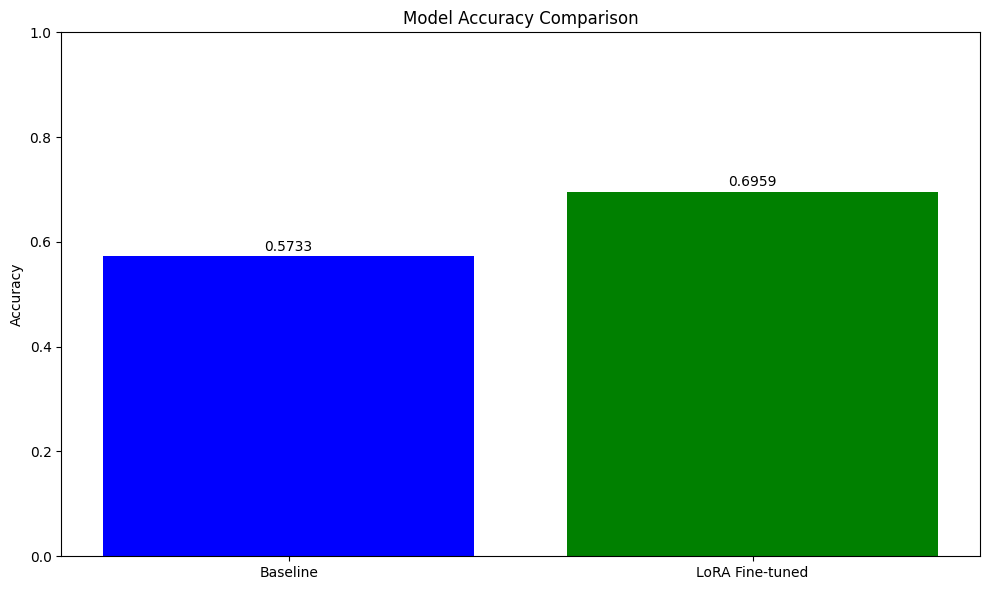

In [22]:
# Cell to evaluate baseline BLIP model and fine-tuned LoRA model on batch4

import torch
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering
from peft import PeftModel

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BASE_MODEL_NAME = "Salesforce/blip-vqa-base"
LORA_MODEL_PATH = "/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/best_model_epoch_3"  # Path to your fine-tuned model
MAX_LENGTH = 32
BATCH_SIZE = 8

print(f"Using device: {DEVICE}")

# Load processor
processor = AutoProcessor.from_pretrained(BASE_MODEL_NAME)

# Ensure the eval_dataloader is available
# If not already created, reload the batch4 dataset
if 'eval_dataloader' not in locals() or 'eval_dataset' not in locals():
    print("Creating evaluation dataset and dataloader...")
    eval_dataset = VQADataset(
        qa_data=qa_data["batch4"],
        base_path=BASE_PATH,
        batch_name="batch4",
        processor=processor,
        max_length=MAX_LENGTH
    )
    
    eval_dataloader = DataLoader(
        eval_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )
    print(f"Evaluation dataset size: {len(eval_dataset)}")

# Define function to evaluate models and collect detailed results
def evaluate_model_with_details(model, dataloader, device=DEVICE, model_name="Model"):
    model.eval()
    model.to(device)
    
    results = {
        "correct": 0,
        "total": 0,
        "predictions": [],
        "ground_truths": [],
        "is_correct": []
    }
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {model_name}"):
            # Move everything to device
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
            
            # Generate predictions
            generated_ids = model.generate(
                pixel_values=batch["pixel_values"],
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=MAX_LENGTH
            )
            
            # Decode predictions and ground truth
            generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
            gt_texts = processor.batch_decode(batch["labels"], skip_special_tokens=True)
            
            # Track results
            for pred, gt in zip(generated_texts, gt_texts):
                pred = pred.strip().lower()
                gt = gt.strip().lower()
                is_correct = (pred == gt)
                
                results["predictions"].append(pred)
                results["ground_truths"].append(gt)
                results["is_correct"].append(is_correct)
                
                if is_correct:
                    results["correct"] += 1
                results["total"] += 1
    
    # Calculate accuracy
    results["accuracy"] = results["correct"] / results["total"] if results["total"] > 0 else 0
    print(f"{model_name} results: {results['correct']}/{results['total']} correct, Accuracy: {results['accuracy']:.4f}")
    
    return results

# 1. Evaluate baseline model
print("\n=== Evaluating Baseline BLIP-VQA Model ===")
baseline_model = AutoModelForVisualQuestionAnswering.from_pretrained(BASE_MODEL_NAME)
baseline_results = evaluate_model_with_details(baseline_model, eval_dataloader, model_name="Baseline")

# Free up memory
del baseline_model
torch.cuda.empty_cache()

# 2. Evaluate fine-tuned LoRA model
print("\n=== Evaluating Fine-tuned LoRA Model ===")
# Load the base model first
base_model = AutoModelForVisualQuestionAnswering.from_pretrained(BASE_MODEL_NAME)
# Then load the LoRA adapter
lora_model = PeftModel.from_pretrained(
    base_model, 
    LORA_MODEL_PATH,
    is_trainable=False
)
lora_results = evaluate_model_with_details(lora_model, eval_dataloader, model_name="LoRA Fine-tuned")

# 3. Compare results
print("\n=== Model Comparison ===")
improvement = (lora_results["accuracy"] - baseline_results["accuracy"]) * 100
print(f"Baseline model accuracy: {baseline_results['accuracy']:.4f}")
print(f"Fine-tuned model accuracy: {lora_results['accuracy']:.4f}")
print(f"Absolute improvement: {improvement:.2f}%")
print(f"Relative improvement: {(improvement/baseline_results['accuracy']):.2f}%")

# 4. Error analysis: Find examples where models disagree
disagreements = [
    (i, baseline_results["predictions"][i], lora_results["predictions"][i], baseline_results["ground_truths"][i])
    for i in range(len(baseline_results["predictions"]))
    if baseline_results["is_correct"][i] != lora_results["is_correct"][i]
]

print(f"\nFound {len(disagreements)} examples where models disagree")
if disagreements:
    print("\nSample disagreements (baseline vs. LoRA vs. ground truth):")
    for i, baseline_pred, lora_pred, gt in disagreements[:5]:  # Show first 5 examples
        baseline_correct = "✓" if baseline_pred == gt else "✗"
        lora_correct = "✓" if lora_pred == gt else "✗"
        print(f"Example {i}:")
        print(f"  Baseline ({baseline_correct}): '{baseline_pred}'")
        print(f"  LoRA ({lora_correct}): '{lora_pred}'")
        print(f"  Ground truth: '{gt}'")
        print()

# 5. Visualization
plt.figure(figsize=(10, 6))
models = ['Baseline', 'LoRA Fine-tuned']
accuracies = [baseline_results["accuracy"], lora_results["accuracy"]]
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

In [24]:
def create_results_csv(baseline_results, lora_results, output_file="vqa_results.csv"):
    """
    Create a CSV file containing all predictions, ground truths, and accuracy results.
    
    Args:
        baseline_results: Results from baseline model evaluation
        lora_results: Results from LoRA fine-tuned model evaluation
        output_file: Path to save the CSV file
    """
    # Create a DataFrame with all results
    results_df = pd.DataFrame({
        'Question_ID': range(len(baseline_results["ground_truths"])),
        'Ground_Truth': baseline_results["ground_truths"],
        'Baseline_Prediction': baseline_results["predictions"],
        'Baseline_Correct': baseline_results["is_correct"],
        'LoRA_Prediction': lora_results["predictions"],
        'LoRA_Correct': lora_results["is_correct"],
        'Models_Agree': [b == l for b, l in zip(baseline_results["predictions"], lora_results["predictions"])]
    })
    
    # Add columns to identify interesting cases
    results_df['LoRA_Improved'] = (~results_df['Baseline_Correct']) & results_df['LoRA_Correct']
    results_df['LoRA_Degraded'] = results_df['Baseline_Correct'] & (~results_df['LoRA_Correct'])
    results_df['Both_Incorrect'] = (~results_df['Baseline_Correct']) & (~results_df['LoRA_Correct'])
    results_df['Both_Correct'] = results_df['Baseline_Correct'] & results_df['LoRA_Correct']
    
    # Save to CSV
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total examples: {len(results_df)}")
    print(f"Baseline accuracy: {baseline_results['accuracy']:.4f}")
    print(f"LoRA accuracy: {lora_results['accuracy']:.4f}")
    print(f"Examples where both models are correct: {results_df['Both_Correct'].sum()} ({results_df['Both_Correct'].sum()/len(results_df):.2%})")
    print(f"Examples where LoRA improved over baseline: {results_df['LoRA_Improved'].sum()} ({results_df['LoRA_Improved'].sum()/len(results_df):.2%})")
    print(f"Examples where LoRA performed worse than baseline: {results_df['LoRA_Degraded'].sum()} ({results_df['LoRA_Degraded'].sum()/len(results_df):.2%})")
    print(f"Examples where both models are incorrect: {results_df['Both_Incorrect'].sum()} ({results_df['Both_Incorrect'].sum()/len(results_df):.2%})")
    
    return results_df

# Use this function after running the model evaluations
results_df = create_results_csv(baseline_results, lora_results)

Results saved to vqa_results.csv

Summary Statistics:
Total examples: 18556
Baseline accuracy: 0.5733
LoRA accuracy: 0.6959
Examples where both models are correct: 9472 (51.05%)
Examples where LoRA improved over baseline: 3442 (18.55%)
Examples where LoRA performed worse than baseline: 1167 (6.29%)
Examples where both models are incorrect: 4475 (24.12%)


Loaded 18556 samples from vqa-results.csv

Calculating BERTScore for Baseline model using distilroberta-base...
Ensuring model distilroberta-base is available...
Model confirmed available


Processing complete batch (18556 samples):   0%|          | 0/580 [00:00<?, ?it/s]

Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/baseline_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/base

Processing complete batch (18556 samples):   0%|          | 0/580 [00:00<?, ?it/s]

Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoints/lora_checkpoint.pkl
Saved checkpoint to ./bertscore_checkpoi

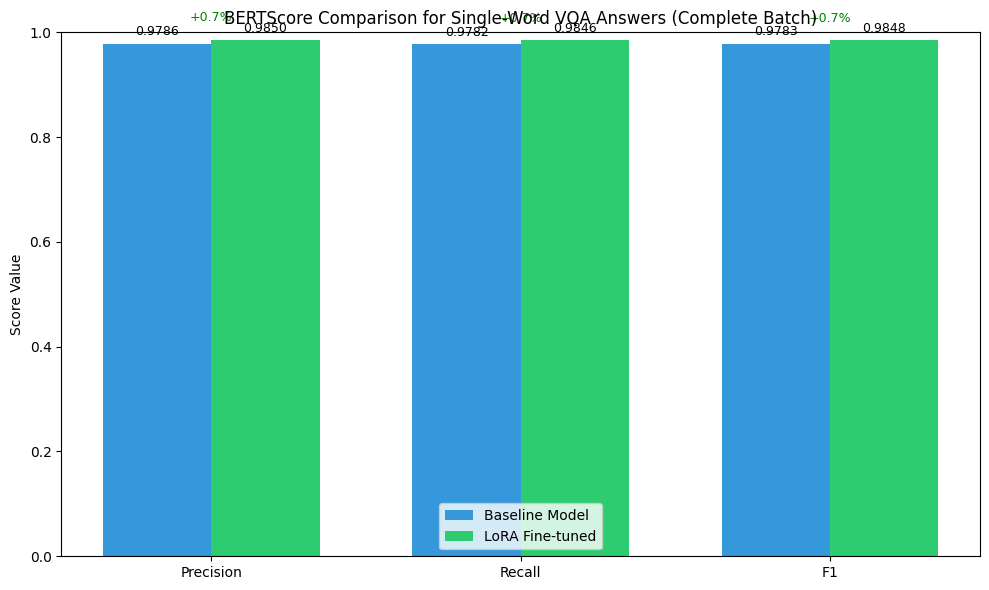

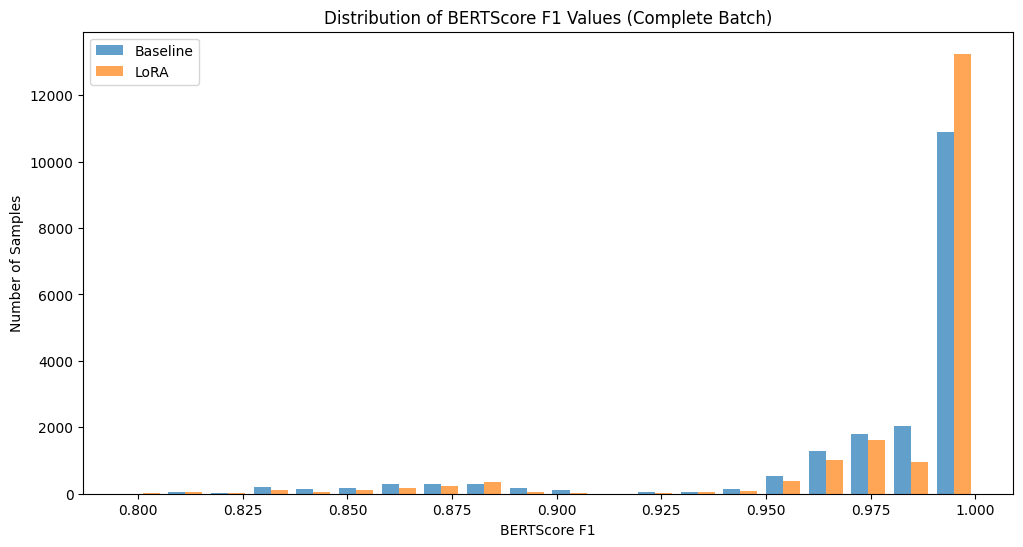

In [29]:
# Install bert-score and huggingface_hub
!pip install bert-score==0.3.13 huggingface_hub -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import os
import json
from bert_score import score as bert_score
import torch
import pickle

# Set a custom cache directory to ensure models are saved
os.environ['TRANSFORMERS_CACHE'] = './hf_cache'
os.environ['HF_HOME'] = './hf_cache'
os.makedirs('./hf_cache', exist_ok=True)

# Load the results CSV
results_df = pd.read_csv('vqa_results.csv')
print(f"Loaded {len(results_df)} samples from vqa-results.csv")

# Extract predictions and ground truths
ground_truths = results_df['Ground_Truth'].tolist()
baseline_predictions = results_df['Baseline_Prediction'].tolist()
lora_predictions = results_df['LoRA_Prediction'].tolist()

# Define checkpoint directory
checkpoint_dir = './bertscore_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(data, filename):
    """Save checkpoint to avoid recomputing on failure"""
    with open(os.path.join(checkpoint_dir, filename), 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved checkpoint to {os.path.join(checkpoint_dir, filename)}")

def load_checkpoint(filename):
    """Load checkpoint if exists"""
    filepath = os.path.join(checkpoint_dir, filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        print(f"Loaded checkpoint from {filepath}")
        return data
    return None

# Calculate BERTScore with robust error handling and verification
def calculate_bert_score_complete(predictions, references, model_type="distilroberta-base", 
                                 batch_size=32, checkpoint_name=None):
    """
    Calculate BERTScore with robust error handling and verification
    Ensures the complete batch is processed without skipping any samples
    """
    total_samples = len(predictions)
    
    # Check if we can resume from checkpoint
    if checkpoint_name:
        checkpoint_data = load_checkpoint(f"{checkpoint_name}_checkpoint.pkl")
        if checkpoint_data and len(checkpoint_data['f1_scores']) == total_samples:
            print(f"Resuming from complete checkpoint. All {total_samples} samples already processed.")
            return checkpoint_data
        elif checkpoint_data:
            print(f"Found partial checkpoint with {len(checkpoint_data['f1_scores'])} of {total_samples} samples.")
            processed_count = len(checkpoint_data['f1_scores'])
            all_P = checkpoint_data['precision_scores']
            all_R = checkpoint_data['recall_scores']
            all_F1 = checkpoint_data['f1_scores']
            start_idx = processed_count - (processed_count % batch_size)  # Restart at batch boundary
            print(f"Resuming from sample {start_idx}/{total_samples}")
        else:
            all_P, all_R, all_F1 = [], [], []
            start_idx = 0
    else:
        all_P, all_R, all_F1 = [], [], []
        start_idx = 0
    
    # Pre-download model to avoid timeouts
    print(f"Ensuring model {model_type} is available...")
    try:
        from transformers import AutoModel, AutoTokenizer
        _ = AutoModel.from_pretrained(model_type)
        _ = AutoTokenizer.from_pretrained(model_type)
        print("Model confirmed available")
    except Exception as e:
        print(f"Warning - model pre-loading issue: {e}")
        print("Will attempt to continue with batch processing...")
    
    # Process in batches with verification
    batch_indices = list(range(start_idx, total_samples, batch_size))
    
    for i in tqdm(batch_indices, desc=f"Processing complete batch ({total_samples} samples)"):
        batch_end = min(i + batch_size, total_samples)
        batch_preds = predictions[i:batch_end]
        batch_refs = references[i:batch_end]
        
        # Handle empty strings
        batch_preds = [p if p and p.strip() else " " for p in batch_preds]
        batch_refs = [r if r and r.strip() else " " for r in batch_refs]
        
        # Process this batch with retries until successful
        batch_processed = False
        retry_count = 0
        max_retries = 15  # More retries to ensure completion
        
        while not batch_processed:
            try:
                # Process the batch
                P, R, F1 = bert_score(
                    batch_preds, 
                    batch_refs, 
                    lang='en', 
                    model_type=model_type,
                    verbose=False,
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    batch_size=min(8, len(batch_preds))  # Smaller internal batch to avoid OOM
                )
                
                # Extend our results
                all_P.extend(P.tolist())
                all_R.extend(R.tolist())
                all_F1.extend(F1.tolist())
                
                # Verify correct number of scores
                expected_count = batch_end - i
                actual_count = len(P.tolist())
                
                if actual_count != expected_count:
                    raise ValueError(f"Batch size mismatch! Expected {expected_count} scores, got {actual_count}.")
                
                batch_processed = True
                
                # Save checkpoint every 5 batches or at the end
                if checkpoint_name and (i % (batch_size * 5) == 0 or batch_end == total_samples):
                    checkpoint_data = {
                        'precision_scores': all_P,
                        'recall_scores': all_R,
                        'f1_scores': all_F1,
                        'precision': np.mean(all_P) if all_P else 0,
                        'recall': np.mean(all_R) if all_R else 0,
                        'f1': np.mean(all_F1) if all_F1 else 0,
                        'last_processed_idx': batch_end - 1,
                        'total_samples': total_samples
                    }
                    save_checkpoint(checkpoint_data, f"{checkpoint_name}_checkpoint.pkl")
                    
            except Exception as e:
                retry_count += 1
                
                # Exponential backoff with jitter
                wait_time = min(2 ** retry_count + np.random.randint(0, 5), 120)
                
                print(f"\nError in batch {i//batch_size + 1}/{len(batch_indices)} (samples {i}-{batch_end-1}): {e}")
                
                if "429" in str(e):
                    print("⚠️ Rate limit hit (HTTP 429). Waiting longer...")
                    wait_time = min(wait_time * 2, 300)  # Wait up to 5 minutes for rate limit
                
                if retry_count <= max_retries:
                    print(f"Retrying in {wait_time}s [Retry {retry_count}/{max_retries}]")
                    time.sleep(wait_time)
                    
                    # Reduce internal batch size after multiple retries
                    if retry_count > 3 and "CUDA out of memory" in str(e):
                        print("Reducing internal batch size to avoid CUDA OOM")
                else:
                    print(f"⚠️ Max retries ({max_retries}) reached for batch starting at index {i}.")
                    print("Using fallback method: processing one sample at a time")
                    
                    # Fallback: Process one by one
                    for j in range(i, batch_end):
                        single_pred = [predictions[j] if predictions[j] and predictions[j].strip() else " "]
                        single_ref = [references[j] if references[j] and references[j].strip() else " "]
                        
                        try:
                            print(f"Processing single sample {j}/{total_samples}")
                            single_P, single_R, single_F1 = bert_score(
                                single_pred, single_ref, lang='en', model_type=model_type,
                                verbose=False, device='cuda' if torch.cuda.is_available() else 'cpu'
                            )
                            all_P.append(single_P.item())
                            all_R.append(single_R.item())
                            all_F1.append(single_F1.item())
                            
                        except Exception as inner_e:
                            print(f"Failed on single sample {j}: {inner_e}")
                            # Use fallback values if even single processing fails
                            print("Using fallback score of 0.5 for this sample")
                            all_P.append(0.5)
                            all_R.append(0.5)
                            all_F1.append(0.5)
                            
                            # Wait after failure to avoid rate limits
                            time.sleep(5)
                    
                    batch_processed = True
    
    # Final verification
    if len(all_F1) != total_samples:
        missing_count = total_samples - len(all_F1)
        print(f"⚠️ WARNING: {missing_count} samples were not processed!")
        
        # Auto-fill missing values if any (shouldn't happen with above logic)
        if len(all_F1) < total_samples:
            missing = total_samples - len(all_F1)
            print(f"Auto-filling {missing} missing values with 0.5")
            all_P.extend([0.5] * missing)
            all_R.extend([0.5] * missing)
            all_F1.extend([0.5] * missing)
    else:
        print(f"✅ Verification successful: All {total_samples} samples were processed")
    
    # Final results
    results = {
        'precision': np.mean(all_P),
        'recall': np.mean(all_R),
        'f1': np.mean(all_F1),
        'precision_scores': all_P,
        'recall_scores': all_R,
        'f1_scores': all_F1,
        'total_processed': len(all_F1),
        'expected_samples': total_samples
    }
    
    # Save final results
    if checkpoint_name:
        save_checkpoint(results, f"{checkpoint_name}_final.pkl")
    
    return results

# Use a smaller, faster model
MODEL_TYPE = "distilroberta-base"

# Calculate BERTScore for baseline model (with checkpointing)
print(f"\nCalculating BERTScore for Baseline model using {MODEL_TYPE}...")
baseline_bert_scores = calculate_bert_score_complete(
    baseline_predictions, 
    ground_truths, 
    model_type=MODEL_TYPE,
    checkpoint_name="baseline"
)

# Calculate BERTScore for LoRA model (with checkpointing)
print(f"\nCalculating BERTScore for LoRA model using {MODEL_TYPE}...")
lora_bert_scores = calculate_bert_score_complete(
    lora_predictions, 
    ground_truths, 
    model_type=MODEL_TYPE,
    checkpoint_name="lora"
)

# Verify both models processed all samples
total_samples = len(ground_truths)
baseline_processed = len(baseline_bert_scores['f1_scores'])
lora_processed = len(lora_bert_scores['f1_scores'])

print("\n===== Processing Verification =====")
print(f"Total samples: {total_samples}")
print(f"Baseline processed: {baseline_processed} samples ({baseline_processed/total_samples:.2%})")
print(f"LoRA processed: {lora_processed} samples ({lora_processed/total_samples:.2%})")

if baseline_processed != total_samples or lora_processed != total_samples:
    print("⚠️ WARNING: Not all samples were processed!")
else:
    print("✅ Complete batch processing confirmed for both models")

# Print summary results
print("\n===== BERTScore Results =====")
print(f"Baseline model - Precision: {baseline_bert_scores['precision']:.4f}, Recall: {baseline_bert_scores['recall']:.4f}, F1: {baseline_bert_scores['f1']:.4f}")
print(f"LoRA model    - Precision: {lora_bert_scores['precision']:.4f}, Recall: {lora_bert_scores['recall']:.4f}, F1: {lora_bert_scores['f1']:.4f}")

# Calculate improvement
baseline_f1 = baseline_bert_scores['f1']
lora_f1 = lora_bert_scores['f1']
absolute_improvement = lora_f1 - baseline_f1
relative_improvement = (absolute_improvement / baseline_f1) * 100

print(f"\nAbsolute BERTScore F1 improvement: {absolute_improvement:.4f}")
print(f"Relative BERTScore F1 improvement: {relative_improvement:.2f}%")

# Add BERTScore to the DataFrame 
results_df['Baseline_BERTScore_F1'] = baseline_bert_scores['f1_scores']
results_df['LoRA_BERTScore_F1'] = lora_bert_scores['f1_scores']

# Save enhanced results
results_df.to_csv('vqa-results-with-bertscore.csv', index=False)
print("\nSaved results with BERTScore to vqa-results-with-bertscore.csv")

# Create visualization
plt.figure(figsize=(10, 6))
metrics = ['Precision', 'Recall', 'F1']
baseline_values = [baseline_bert_scores['precision'], baseline_bert_scores['recall'], baseline_bert_scores['f1']]
lora_values = [lora_bert_scores['precision'], lora_bert_scores['recall'], lora_bert_scores['f1']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, baseline_values, width, label='Baseline Model', color='#3498db')
plt.bar(x + width/2, lora_values, width, label='LoRA Fine-tuned', color='#2ecc71')

plt.ylim(0, 1.0)
plt.ylabel('Score Value')
plt.title('BERTScore Comparison for Single-Word VQA Answers (Complete Batch)')
plt.xticks(x, metrics)
plt.legend(loc='lower center')

# Add values on top of bars
for i, v in enumerate(baseline_values):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

for i, v in enumerate(lora_values):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# Add improvement percentages
for i, (bv, lv) in enumerate(zip(baseline_values, lora_values)):
    if bv > 0:
        pct_change = (lv - bv) / bv * 100
        if abs(pct_change) > 0.1:
            color = 'green' if pct_change > 0 else 'red'
            plt.text(i, max(bv, lv) + 0.03, f"{pct_change:+.1f}%", ha='center', va='bottom', 
                    fontsize=9, color=color)

plt.tight_layout()
plt.savefig('bertscore_comparison.png')
plt.show()

# Analysis of BERTScore distribution
plt.figure(figsize=(12, 6))
plt.hist([baseline_bert_scores['f1_scores'], lora_bert_scores['f1_scores']], 
         bins=20, alpha=0.7, label=['Baseline', 'LoRA'])
plt.xlabel('BERTScore F1')
plt.ylabel('Number of Samples')
plt.title('Distribution of BERTScore F1 Values (Complete Batch)')
plt.legend()
plt.savefig('bertscore_distribution.png')
plt.show()

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter, defaultdict

# Load the results with BERTScore
results_df = pd.read_csv('vqa-results-with-bertscore.csv')
print(f"Loaded {len(results_df)} results with BERTScore")

# Function to extract question type
def extract_question_type(question):
    """Extract the type of question based on the first few words"""
    question = question.lower().strip()
    
    # Define patterns for question types
    patterns = {
        'what color': r'^what colou?r',
        'what shape': r'^what shape',
        'what pattern': r'^what pattern',
        'what material': r'^what material',
        'what type': r'^what (type|kind)',
        'what is': r'^what is',
        'what': r'^what',
        'how many': r'^how many',
        'is there': r'^is there',
        'are there': r'^are there',
        'does': r'^does',
        'is the': r'^is the',
        'are the': r'^are the',
        'can': r'^can',
        'where': r'^where'
    }
    
    for q_type, pattern in patterns.items():
        if re.search(pattern, question):
            return q_type
    
    # Use first word as fallback
    first_word = question.split()[0] if question else 'unknown'
    return first_word

# Need to add questions to our dataframe since they're not in the CSV
# Assuming we have access to the original QA dataset
# Let's reconstruct from qa_data if possible or create a dummy version if not

# Option 1: If you have access to qa_data from the original notebook
try:
    base_path = 'vqa_data/dataset-batches/'
    with open(os.path.join(base_path, 'batch4_qa_dataset.json'), 'r') as f:
        batch4_data = json.load(f)
    
    # Extract questions and create a list
    questions = []
    for item in batch4_data:
        for qa_pair in item['qa_pairs']:
            questions.append(qa_pair['question'])
    
    print(f"Loaded {len(questions)} questions from batch4_qa_dataset.json")
    
    # Add questions to the DataFrame
    if len(questions) == len(results_df):
        results_df['Question'] = questions
    else:
        print(f"Warning: Number of questions ({len(questions)}) doesn't match results ({len(results_df)})")
        # Try to match based on ground truth answers if there's a mismatch
        
except Exception as e:
    print(f"Could not load original dataset: {e}")
    # Option 2: Create dummy questions based on common patterns in the ABO dataset
    print("Creating sample questions based on ground truths...")
    
    def generate_question(ground_truth):
        """Generate a plausible question based on the answer"""
        gt = ground_truth.lower()
        
        # Color answers
        if gt in ['red', 'blue', 'green', 'black', 'white', 'silver', 'gold', 'brown', 'yellow', 'orange', 'purple', 'pink', 'gray', 'grey', 'beige']:
            return "What color is the item?"
        
        # Shape answers
        elif gt in ['round', 'square', 'rectangular', 'oval', 'circular', 'triangle', 'triangular', 'rectangle', 'circle']:
            return "What shape is the item?"
        
        # Number answers
        elif gt in ['one', 'two', 'three', 'four', 'five', 'six', '1', '2', '3', '4', '5', '6']:
            return "How many items are visible?"
        
        # Yes/No answers
        elif gt in ['yes', 'no']:
            return "Is the item decorative?"
        
        # Material answers
        elif gt in ['wood', 'metal', 'plastic', 'glass', 'fabric', 'leather', 'ceramic', 'steel', 'cotton', 'aluminum']:
            return "What material is the item made of?"
        
        # Pattern answers
        elif gt in ['striped', 'solid', 'patterned', 'floral', 'plain', 'checkered', 'dotted', 'geometric']:
            return "What pattern is on the item?"
        
        # Default
        else:
            return "What is the main feature of this item?"
    
    # Generate questions
    questions = [generate_question(gt) for gt in results_df['Ground_Truth']]
    results_df['Question'] = questions

# Extract question types
results_df['Question_Type'] = results_df['Question'].apply(extract_question_type)

# Count question types
question_type_counts = results_df['Question_Type'].value_counts()
print("\nQuestion Type Distribution:")
for q_type, count in question_type_counts.items():
    print(f"{q_type}: {count} ({count/len(results_df):.1%})")

# Calculate performance by question type
performance_by_type = results_df.groupby('Question_Type').agg({
    'Baseline_Correct': 'mean',
    'LoRA_Correct': 'mean',
    'Baseline_BERTScore_F1': 'mean',
    'LoRA_BERTScore_F1': 'mean'
}).reset_index()

# Add improvement metrics
performance_by_type['Accuracy_Improvement'] = performance_by_type['LoRA_Correct'] - performance_by_type['Baseline_Correct']
performance_by_type['BERTScore_Improvement'] = performance_by_type['LoRA_BERTScore_F1'] - performance_by_type['Baseline_BERTScore_F1']
performance_by_type['Relative_Accuracy_Improvement'] = performance_by_type['Accuracy_Improvement'] / performance_by_type['Baseline_Correct']
performance_by_type['Relative_BERTScore_Improvement'] = performance_by_type['BERTScore_Improvement'] / performance_by_type['Baseline_BERTScore_F1']

# Sort by improvement
performance_by_type_sorted = performance_by_type.sort_values('Accuracy_Improvement', ascending=False)

# Display results
print("\nPerformance by Question Type (Sorted by Accuracy Improvement):")
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)
display(performance_by_type_sorted)

Loaded 18556 results with BERTScore
Loaded 18556 questions from batch4_qa_dataset.json

Question Type Distribution:
what is: 5140 (27.7%)
what color: 4255 (22.9%)
what shape: 3188 (17.2%)
are there: 1946 (10.5%)
is there: 1380 (7.4%)
is the: 797 (4.3%)
how many: 756 (4.1%)
are the: 429 (2.3%)
does: 237 (1.3%)
what: 211 (1.1%)
what pattern: 125 (0.7%)
what material: 45 (0.2%)
what type: 40 (0.2%)
is: 5 (0.0%)
are: 2 (0.0%)

Performance by Question Type (Sorted by Accuracy Improvement):


,Question_Type,Baseline_Correct,LoRA_Correct,Baseline_BERTScore_F1,LoRA_BERTScore_F1,Accuracy_Improvement,BERTScore_Improvement,Relative_Accuracy_Improvement,Relative_BERTScore_Improvement
0,are,0.5000,1.0000,0.9929,1.0000,0.5000,7.0724e-03,1.0000,7.1228e-03
4,how many,0.0212,0.4762,0.9825,0.9943,0.4550,1.1852e-02,21.5000,1.2063e-02
14,what type,0.2000,0.5750,0.9396,0.9677,0.3750,2.8095e-02,1.8750,2.9901e-02
8,what,0.3270,0.4976,0.9475,0.9665,0.1706,1.8953e-02,0.5217,2.0003e-02
12,what pattern,0.3120,0.4720,0.9342,0.9462,0.1600,1.2026e-02,0.5128,1.2873e-02
10,what is,0.4255,0.5846,0.9632,0.9745,0.1591,1.1265e-02,0.3740,1.1696e-02
9,what color,0.6432,0.7551,0.9808,0.9874,0.1119,6.6128e-03,0.1739,6.7424e-03
11,what material,0.6222,0.7333,0.9810,0.9869,0.1111,5.8584e-03,0.1786,5.9718e-03
6,is the,0.8080,0.9109,0.9973,0.9987,0.1029,1.4562e-03,0.1273,1.4602e-03
3,does,0.8819,0.9747,0.9983,0.9996,0.0928,1.3130e-03,0.1053,1.3152e-03


In [32]:
# Create a confusion matrix for each question type
def analyze_question_type_errors(question_type):
    """Analyze errors for a specific question type"""
    type_df = results_df[results_df['Question_Type'] == question_type]
    
    if len(type_df) < 5:
        return None  # Skip if too few examples
    
    # Count occurrences of each ground truth - prediction pair
    baseline_error_counts = defaultdict(Counter)
    lora_error_counts = defaultdict(Counter)
    
    for _, row in type_df.iterrows():
        gt = row['Ground_Truth']
        baseline_pred = row['Baseline_Prediction']
        lora_pred = row['LoRA_Prediction']
        
        baseline_error_counts[gt][baseline_pred] += 1
        lora_error_counts[gt][lora_pred] += 1
    
    # Get top errors
    baseline_errors = []
    for gt, preds in baseline_error_counts.items():
        for pred, count in preds.items():
            if gt.lower() != pred.lower():  # Only include actual errors
                baseline_errors.append((gt, pred, count))
    
    lora_errors = []
    for gt, preds in lora_error_counts.items():
        for pred, count in preds.items():
            if gt.lower() != pred.lower():  # Only include actual errors
                lora_errors.append((gt, pred, count))
    
    # Sort by count
    baseline_errors.sort(key=lambda x: x[2], reverse=True)
    lora_errors.sort(key=lambda x: x[2], reverse=True)
    
    return {
        'question_type': question_type,
        'count': len(type_df),
        'baseline_accuracy': type_df['Baseline_Correct'].mean(),
        'lora_accuracy': type_df['LoRA_Correct'].mean(),
        'baseline_top_errors': baseline_errors[:5],  # Top 5 errors
        'lora_top_errors': lora_errors[:5],  # Top 5 errors
        'baseline_bert': type_df['Baseline_BERTScore_F1'].mean(),
        'lora_bert': type_df['LoRA_BERTScore_F1'].mean(),
    }

# Analyze each question type with sufficient examples
min_examples = 10
question_types_to_analyze = [
    qt for qt, count in question_type_counts.items() if count >= min_examples
]

error_analyses = []
for qt in question_types_to_analyze:
    analysis = analyze_question_type_errors(qt)
    if analysis:
        error_analyses.append(analysis)

# Sort by improvement
error_analyses.sort(key=lambda x: x['lora_accuracy'] - x['baseline_accuracy'], reverse=True)

# Display results for each question type
for analysis in error_analyses:
    qt = analysis['question_type']
    count = analysis['count']
    b_acc = analysis['baseline_accuracy']
    l_acc = analysis['lora_accuracy']
    improvement = l_acc - b_acc
    
    print(f"\n==== Question Type: {qt} ({count} examples) ====")
    print(f"Baseline Accuracy: {b_acc:.4f}")
    print(f"LoRA Accuracy: {l_acc:.4f}")
    print(f"Improvement: {improvement:.4f} ({improvement/b_acc*100 if b_acc > 0 else 0:.1f}%)")
    print(f"BERTScore: Baseline {analysis['baseline_bert']:.4f} → LoRA {analysis['lora_bert']:.4f}")
    
    print("\nTop Baseline Errors (Ground Truth → Incorrect Prediction):")
    for gt, pred, count in analysis['baseline_top_errors']:
        print(f"  '{gt}' → '{pred}': {count} times ({count/analysis['count']:.1%})")
    
    print("\nTop LoRA Errors (Ground Truth → Incorrect Prediction):")
    for gt, pred, count in analysis['lora_top_errors']:
        print(f"  '{gt}' → '{pred}': {count} times ({count/analysis['count']:.1%})")
    
    print("\nExamples of fixed/worsened answers:")
    
    # Find examples where LoRA fixed baseline errors
    fixed = results_df[(results_df['Question_Type'] == qt) & 
                        (~results_df['Baseline_Correct']) & 
                        (results_df['LoRA_Correct'])].head(3)
    
    if not fixed.empty:
        print("  Examples where LoRA fixed baseline errors:")
        for _, row in fixed.iterrows():
            print(f"    Q: '{row['Question']}'")
            print(f"    GT: '{row['Ground_Truth']}', Baseline: '{row['Baseline_Prediction']}', LoRA: '{row['LoRA_Prediction']}'")
    
    # Find examples where LoRA worsened baseline correct answers
    worsened = results_df[(results_df['Question_Type'] == qt) & 
                          (results_df['Baseline_Correct']) & 
                          (~results_df['LoRA_Correct'])].head(3)
    
    if not worsened.empty:
        print("\n  Examples where LoRA worsened baseline correct answers:")
        for _, row in worsened.iterrows():
            print(f"    Q: '{row['Question']}'")
            print(f"    GT: '{row['Ground_Truth']}', Baseline: '{row['Baseline_Prediction']}', LoRA: '{row['LoRA_Prediction']}'")


==== Question Type: how many (756 examples) ====
Baseline Accuracy: 0.0212
LoRA Accuracy: 0.4762
Improvement: 0.4550 (2150.0%)
BERTScore: Baseline 0.9825 → LoRA 0.9943

Top Baseline Errors (Ground Truth → Incorrect Prediction):
  'two' → '2': 116 times (15.3%)
  'four' → '4': 51 times (6.7%)
  'four' → '6': 47 times (6.2%)
  'three' → '4': 44 times (5.8%)
  'six' → '6': 33 times (4.4%)

Top LoRA Errors (Ground Truth → Incorrect Prediction):
  'three' → 'two': 106 times (14.0%)
  'six' → 'ten': 35 times (4.6%)
  'four' → 'two': 34 times (4.5%)
  'three' → 'four': 16 times (2.1%)
  'four' → 'five': 12 times (1.6%)

Examples of fixed/worsened answers:
  Examples where LoRA fixed baseline errors:
    Q: 'How many earrings are visible?'
    GT: 'two', Baseline: '3', LoRA: 'two'
    Q: 'How many USB ports are visible?'
    GT: 'two', Baseline: '2', LoRA: 'two'
    Q: 'How many earrings are visible?'
    GT: 'two', Baseline: '3', LoRA: 'two'

  Examples where LoRA worsened baseline correct a

In [33]:
# Find individual examples with the largest improvement and degradation
results_df['BERTScore_Improvement'] = results_df['LoRA_BERTScore_F1'] - results_df['Baseline_BERTScore_F1']

# Most improved examples
most_improved = results_df[~results_df['Baseline_Correct'] & results_df['LoRA_Correct']].sort_values('BERTScore_Improvement', ascending=False)

# Most degraded examples
most_degraded = results_df[results_df['Baseline_Correct'] & ~results_df['LoRA_Correct']].sort_values('BERTScore_Improvement')

# Display most improved examples
print("\n===== Most Improved Examples (Fixed by LoRA) =====")
if len(most_improved) > 0:
    for i, (_, row) in enumerate(most_improved.head(10).iterrows()):
        print(f"\nExample {i+1} (Question Type: {row['Question_Type']}):")
        print(f"  Question: '{row['Question']}'")
        print(f"  Ground Truth: '{row['Ground_Truth']}'")
        print(f"  Baseline: '{row['Baseline_Prediction']}' (BERTScore: {row['Baseline_BERTScore_F1']:.4f})")
        print(f"  LoRA: '{row['LoRA_Prediction']}' (BERTScore: {row['LoRA_BERTScore_F1']:.4f})")
        print(f"  Improvement: {row['BERTScore_Improvement']:.4f}")
else:
    print("No examples found where LoRA fixed incorrect baseline predictions.")

# Display most degraded examples
print("\n===== Most Degraded Examples (Worsened by LoRA) =====")
if len(most_degraded) > 0:
    for i, (_, row) in enumerate(most_degraded.head(10).iterrows()):
        print(f"\nExample {i+1} (Question Type: {row['Question_Type']}):")
        print(f"  Question: '{row['Question']}'")
        print(f"  Ground Truth: '{row['Ground_Truth']}'")
        print(f"  Baseline: '{row['Baseline_Prediction']}' (BERTScore: {row['Baseline_BERTScore_F1']:.4f})")
        print(f"  LoRA: '{row['LoRA_Prediction']}' (BERTScore: {row['LoRA_BERTScore_F1']:.4f})")
        print(f"  Degradation: {row['BERTScore_Improvement']:.4f}")
else:
    print("No examples found where LoRA worsened correct baseline predictions.")

# Calculate transition statistics
transitions = pd.crosstab(
    results_df['Baseline_Correct'], 
    results_df['LoRA_Correct'], 
    rownames=['Baseline'], 
    colnames=['LoRA']
)

print("\n===== Transition Statistics =====")
print(transitions)

# Calculate transition percentages
transitions_pct = pd.crosstab(
    results_df['Baseline_Correct'], 
    results_df['LoRA_Correct'], 
    rownames=['Baseline'], 
    colnames=['LoRA'],
    normalize='index'
) * 100

print("\nTransition Percentages (row percentages):")
print(transitions_pct.round(2))

# Overall summary
total = len(results_df)
stayed_correct = ((results_df['Baseline_Correct']) & (results_df['LoRA_Correct'])).sum()
stayed_wrong = ((~results_df['Baseline_Correct']) & (~results_df['LoRA_Correct'])).sum()
improved = ((~results_df['Baseline_Correct']) & (results_df['LoRA_Correct'])).sum()
degraded = ((results_df['Baseline_Correct']) & (~results_df['LoRA_Correct'])).sum()

print("\n===== Overall Impact Summary =====")
print(f"Total examples: {total}")
print(f"Stayed correct: {stayed_correct} ({stayed_correct/total:.2%})")
print(f"Stayed wrong: {stayed_wrong} ({stayed_wrong/total:.2%})")
print(f"Improved (wrong → correct): {improved} ({improved/total:.2%})")
print(f"Degraded (correct → wrong): {degraded} ({degraded/total:.2%})")
print(f"Net improvement: {improved - degraded} examples ({(improved - degraded)/total:.2%})")


===== Most Improved Examples (Fixed by LoRA) =====

Example 1 (Question Type: what is):
  Question: 'What is the bowl made of?'
  Ground Truth: 'unknown'
  Baseline: 'porcelain' (BERTScore: 0.7959)
  LoRA: 'unknown' (BERTScore: 1.0000)
  Improvement: 0.2041

Example 2 (Question Type: what is):
  Question: 'What is the shape of the container?'
  Ground Truth: 'cylindrical'
  Baseline: 'round' (BERTScore: 0.8095)
  LoRA: 'cylindrical' (BERTScore: 1.0000)
  Improvement: 0.1905

Example 3 (Question Type: what is):
  Question: 'What is the shape of the can?'
  Ground Truth: 'cylindrical'
  Baseline: 'round' (BERTScore: 0.8095)
  LoRA: 'cylindrical' (BERTScore: 1.0000)
  Improvement: 0.1905

Example 4 (Question Type: what shape):
  Question: 'What shape is the can?'
  Ground Truth: 'cylindrical'
  Baseline: 'round' (BERTScore: 0.8095)
  LoRA: 'cylindrical' (BERTScore: 1.0000)
  Improvement: 0.1905

Example 5 (Question Type: what shape):
  Question: 'What shape are the tumblers?'
  Ground Tr

Second fine tunning

In [1]:
# Download the additional batches from Google Drive
!pip install gdown -q
import os

# Create a directory for the new data
!mkdir -p new_batches

# Download the file
!gdown --id 1eyrVTWOc9-QMdwyW8zll-NfUNruRC2Wv -O new_batches/additional_batches.zip

# Extract the zip file
!unzip -q new_batches/additional_batches.zip -d new_batches/

# Check the structure of the downloaded data
!ls -la new_batches/

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1eyrVTWOc9-QMdwyW8zll-NfUNruRC2Wv
From (redirected): https://drive.google.com/uc?id=1eyrVTWOc9-QMdwyW8zll-NfUNruRC2Wv&confirm=t&uuid=17d851b1-b638-4f89-b41c-ed3a395385d5
To: /kaggle/working/new_batches/additional_batches.zip
100%|████████████████████████████████████████| 216M/216M [00:02<00:00, 92.0MB/s]
total 274748
drwxr-xr-x 8 root root      4096 May 18 11:39 .
drwxr-xr-x 4 root root      4096 May 18 11:39 ..
-rw-r--r-- 1 root root 216190666 May 17 21:38 additional_batches.zip
drwxrwxrwx 2 root root    159744 May 11 18:27 batch1
-rw-rw-rw- 1 root root   7316798 May 11 18:37 batch1_metadata.json
-rw-rw-rw- 1 root root   4088213 May 12 04:24 batch1_qa_dataset.json
drwxrwxrwx 2 root root    159744 May 11 18

In [2]:
import json
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.auto import tqdm

# Function to extract question type
def extract_question_type(question):
    """Extract the type of question based on the first few words"""
    question = question.lower().strip()
    
    # Define patterns for question types
    patterns = {
        'what color': r'^what colou?r',
        'what shape': r'^what shape',
        'what pattern': r'^what pattern',
        'what material': r'^what material',
        'what type': r'^what (type|kind)',
        'what is': r'^what is',
        'what': r'^what',
        'how many': r'^how many',
        'is there': r'^is there',
        'are there': r'^are there',
        'does': r'^does',
        'is the': r'^is the',
        'are the': r'^are the',
        'can': r'^can',
        'where': r'^where'
    }
    
    for q_type, pattern in patterns.items():
        if re.search(pattern, question):
            return q_type
    
    # Use first word as fallback
    first_word = question.split()[0] if question else 'unknown'
    return first_word

# Check the new data structure
!find new_batches -type f | grep -i "json"

new_batches/batch4_qa_dataset.json
new_batches/batch1_qa_dataset.json
new_batches/batch2_qa_dataset.json
new_batches/batch3_metadata.json
new_batches/batch4_metadata.json
new_batches/batch6_metadata.json
new_batches/batch5_qa_dataset.json
new_batches/batch1_metadata.json
new_batches/batch3_qa_dataset.json
new_batches/batch2_metadata.json
new_batches/batch6_qa_dataset.json
new_batches/batch5_metadata.json


In [3]:
# Load the QA datasets from the new batches
all_new_qa_data = []

json_files = []
for root, dirs, files in os.walk("new_batches"):
    for file in files:
        if file.endswith(".json"):
            json_files.append(os.path.join(root, file))

print(f"Found {len(json_files)} JSON files")

for json_file in json_files:
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            qa_data = json.load(f)
            if isinstance(qa_data, list) and len(qa_data) > 0 and 'qa_pairs' in qa_data[0]:
                batch_name = os.path.basename(json_file).split('_')[0]
                print(f"Loaded {json_file} with {len(qa_data)} items")
                
                # Add batch identifier to each item
                for item in qa_data:
                    item['batch'] = batch_name
                
                all_new_qa_data.extend(qa_data)
    except Exception as e:
        print(f"Error loading {json_file}: {e}")

print(f"Total items loaded from new batches: {len(all_new_qa_data)}")

# Show sample item structure
if len(all_new_qa_data) > 0:
    print("\nSample item structure:")
    print(json.dumps(all_new_qa_data[0], indent=2)[:500] + "...")

Found 12 JSON files
Loaded new_batches/batch4_qa_dataset.json with 4639 items
Loaded new_batches/batch1_qa_dataset.json with 5078 items
Loaded new_batches/batch2_qa_dataset.json with 4885 items
Loaded new_batches/batch5_qa_dataset.json with 3319 items
Loaded new_batches/batch3_qa_dataset.json with 4753 items
Loaded new_batches/batch6_qa_dataset.json with 4987 items
Total items loaded from new batches: 27661

Sample item structure:
{
  "image_filename": "318-RECETzL.jpg",
  "metadata": {
    "item_id": "B00P2AE2AM",
    "image_id": "318-RECETzL",
    "item_name": " AJC Collection K18PG \u94bb\u77f3\u8033\u73af ajp04pg ",
    "brand": "AJC Collection(AJC \u30b3\u30ec\u30af\u30b7\u30e7\u30f3)",
    "product_type": "FINEEARRING"
  },
  "qa_pairs": [
    {
      "question": "What shape are the earrings?",
      "answer": "Heart"
    },
    {
      "question": "What color is the metal?",
      "answer": "Gold"
    },
    {
    ...



Question Type Distribution in New Batches:
what is: 30438 (27.5%)
what color: 25524 (23.1%)
what shape: 19379 (17.5%)
are there: 11702 (10.6%)
is there: 8163 (7.4%)
is the: 4823 (4.4%)
how many: 4269 (3.9%)
are the: 2414 (2.2%)
does: 1391 (1.3%)
what: 1245 (1.1%)
what pattern: 780 (0.7%)
what material: 252 (0.2%)
what type: 197 (0.2%)
is: 34 (0.0%)
are: 23 (0.0%)
do: 6 (0.0%)
where: 3 (0.0%)
how: 1 (0.0%)

Target question types: ['how many', 'what type', 'what', 'what pattern', 'what shape']

Filtered 25870 questions of target types out of 110644 total

Filtered Question Type Distribution:
what shape: 19379 (74.9%)
how many: 4269 (16.5%)
what: 1245 (4.8%)
what pattern: 780 (3.0%)
what type: 197 (0.8%)


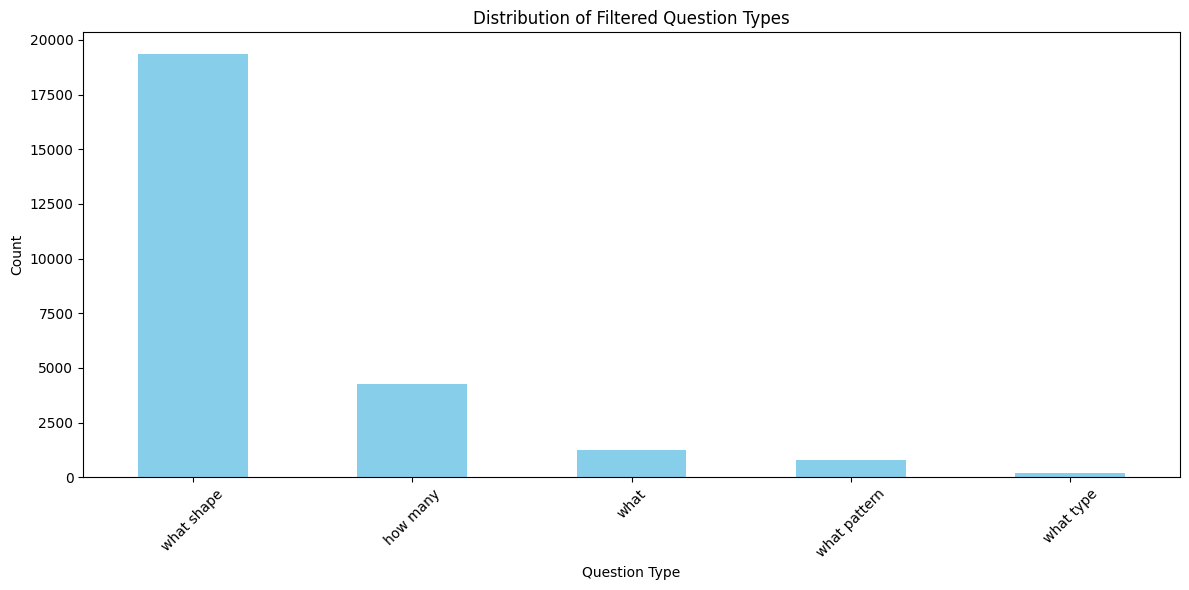

In [4]:
# Extract all questions and their types from the new batches
questions_data = []

for item in all_new_qa_data:
    image_filename = item.get('image_filename', '')
    batch = item.get('batch', '')
    
    for qa_pair in item.get('qa_pairs', []):
        question = qa_pair.get('question', '')
        answer = qa_pair.get('answer', '')
        question_type = extract_question_type(question)
        
        questions_data.append({
            'batch': batch,
            'image_filename': image_filename,
            'question': question,
            'answer': answer,
            'question_type': question_type
        })

# Convert to DataFrame for analysis
questions_df = pd.DataFrame(questions_data)

# Analyze question type distribution
question_type_counts = questions_df['question_type'].value_counts()
print("\nQuestion Type Distribution in New Batches:")
for q_type, count in question_type_counts.items():
    print(f"{q_type}: {count} ({count/len(questions_df):.1%})")

# Identify the problematic question types we want to focus on
target_question_types = ['how many', 'what type', 'what', 'what pattern', 'what shape']
print(f"\nTarget question types: {target_question_types}")

# Filter questions of those types
filtered_questions = questions_df[questions_df['question_type'].isin(target_question_types)]
print(f"\nFiltered {len(filtered_questions)} questions of target types out of {len(questions_df)} total")

# Display count by question type in filtered set
filtered_type_counts = filtered_questions['question_type'].value_counts()
print("\nFiltered Question Type Distribution:")
for q_type, count in filtered_type_counts.items():
    print(f"{q_type}: {count} ({count/len(filtered_questions):.1%})")

# Visualize the distribution
plt.figure(figsize=(12, 6))
filtered_type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Filtered Question Types')
plt.xlabel('Question Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Group filtered questions by image to maintain the structure of the original dataset
filtered_questions_by_image = defaultdict(list)

for _, row in filtered_questions.iterrows():
    key = (row['batch'], row['image_filename'])
    filtered_questions_by_image[key].append({
        'question': row['question'],
        'answer': row['answer']
    })

# Reconstruct the dataset structure
filtered_qa_data = []

for (batch, image_filename), qa_pairs in filtered_questions_by_image.items():
    # Find the original item to preserve metadata
    original_item = None
    for item in all_new_qa_data:
        if item.get('image_filename') == image_filename and item.get('batch', '') == batch:
            original_item = item
            break
    
    if original_item:
        # Create a new item with only the filtered questions
        new_item = {
            'image_filename': image_filename,
            'metadata': original_item.get('metadata', {}),
            'qa_pairs': qa_pairs,
            'processed_at': original_item.get('processed_at', '')
        }
        filtered_qa_data.append(new_item)

print(f"Created filtered dataset with {len(filtered_qa_data)} images and {sum(len(item['qa_pairs']) for item in filtered_qa_data)} QA pairs")

# Save the filtered dataset for future fine-tuning
os.makedirs('filtered_data', exist_ok=True)
with open('filtered_data/filtered_qa_dataset.json', 'w') as f:
    json.dump(filtered_qa_data, f)

print("Saved filtered dataset to filtered_data/filtered_qa_dataset.json")

# Check if we need to copy images
print("\nChecking image paths...")
image_paths = []
for root, dirs, files in os.walk("new_batches"):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} image files in the new batches")

Created filtered dataset with 21760 images and 25870 QA pairs
Saved filtered dataset to filtered_data/filtered_qa_dataset.json

Checking image paths...
Found 29461 image files in the new batches


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering
from PIL import Image
import os

class FilteredVQADataset(Dataset):
    def __init__(self, qa_data, images_dir, processor, max_length=32):
        """
        Initialize the filtered VQA dataset.
        
        Args:
            qa_data: List of QA items
            images_dir: Directory containing image files
            processor: BLIP processor for tokenization and image processing
            max_length: Maximum sequence length
        """
        self.qa_data = qa_data
        self.images_dir = images_dir
        self.processor = processor
        self.max_length = max_length
        
        # Flatten the dataset structure for one entry per QA pair
        self.examples = []
        self.image_paths = {}
        
        for item in qa_data:
            image_filename = item['image_filename']
            
            # Try to find the image file with different paths
            image_path = None
            for root, dirs, files in os.walk(images_dir):
                if image_filename in files:
                    image_path = os.path.join(root, image_filename)
                    break
            
            if image_path:
                self.image_paths[image_filename] = image_path
                for qa_pair in item['qa_pairs']:
                    self.examples.append({
                        'image_filename': image_filename,
                        'question': qa_pair['question'],
                        'answer': qa_pair['answer'],
                    })
        
        print(f"Created dataset with {len(self.examples)} examples from {len(self.image_paths)} images")
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        
        try:
            image_path = self.image_paths[example['image_filename']]
            image = Image.open(image_path).convert('RGB')
            
            # Process the input (image + question)
            inputs = self.processor(
                images=image, 
                text=example['question'], 
                return_tensors="pt",
                padding="max_length",
                max_length=self.max_length,
                truncation=True
            )
            
            # Remove batch dimension
            for k, v in inputs.items():
                inputs[k] = v.squeeze(0)
            
            # Process the target (answer)
            target = self.processor.tokenizer(
                example['answer'],
                padding="max_length",
                max_length=self.max_length,
                truncation=True,
                return_tensors="pt"
            )
            
            inputs["labels"] = target["input_ids"].squeeze(0)
            
            return inputs
            
        except Exception as e:
            print(f"Error processing image {example['image_filename']}: {e}")
            # Return a placeholder in case of error
            return self[0] if idx != 0 else None

# Function to create a dataset from filtered data
def create_filtered_dataset(processor, filtered_data_path, images_dir, max_length=32):
    # Load filtered dataset
    with open(filtered_data_path, 'r') as f:
        filtered_qa_data = json.load(f)
    
    print(f"Loaded filtered dataset with {len(filtered_qa_data)} items")
    
    # Create dataset
    filtered_dataset = FilteredVQADataset(
        qa_data=filtered_qa_data,
        images_dir=images_dir,
        processor=processor,
        max_length=max_length
    )
    
    return filtered_dataset

2025-05-18 11:43:04.636371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747568584.822423      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747568584.876810      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
import gc
from safetensors.torch import load_file

# Set configurations
MODEL_NAME = "Salesforce/blip-vqa-base"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 8  
MAX_LENGTH = 32
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
NUM_EPOCHS = 3
LORA_RANK = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.1

# Path to your current best model
PREVIOUS_LORA_PATH = "/kaggle/input/latest-lora_vqa/pytorch/default/1/blip_lora_checkpoints/best_model_epoch_3" 

print(f"Using device: {DEVICE}")

# Initialize model and processor
processor = AutoProcessor.from_pretrained(MODEL_NAME)
base_model = AutoModelForVisualQuestionAnswering.from_pretrained(MODEL_NAME)

# Configure LoRA
lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    target_modules=["query", "value", "key"]  # Target attention modules
)

# Apply LoRA to base model
new_model = get_peft_model(base_model, lora_config)

if os.path.exists(os.path.join(PREVIOUS_LORA_PATH, "adapter_model.safetensors")):
    state_dict = load_file(os.path.join(PREVIOUS_LORA_PATH, "adapter_model.safetensors"))
    new_model.load_state_dict(state_dict, strict=False)
else:
    new_model.load_state_dict(torch.load(os.path.join(PREVIOUS_LORA_PATH, "adapter_model.bin")), strict=False)

new_model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in new_model.parameters())
trainable_params = sum(p.numel() for p in new_model.parameters() if p.requires_grad)
trainable_pct = 100 * trainable_params / total_params

print(f"\n🔢 Total parameters: {total_params:,}")
print(f"🧠 Trainable parameters: {trainable_params:,}")
print(f"📊 Trainable percentage: {trainable_pct:.2f}%")

# Create filtered dataset
# First check where to find images
images_dir = "new_batches"  # Default
for root, dirs, files in os.walk("new_batches"):
    if any(file.endswith(('.jpg', '.jpeg', '.png')) for file in files):
        images_dir = root
        break

print(f"Using images directory: {images_dir}")

filtered_dataset = create_filtered_dataset(
    processor=processor,
    filtered_data_path='filtered_data/filtered_qa_dataset.json',
    images_dir=images_dir,
    max_length=MAX_LENGTH
)

# Create DataLoader
filtered_dataloader = DataLoader(
    filtered_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

print(f"DataLoader created with {len(filtered_dataset)} examples")

# Setup optimizer
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, new_model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

Using device: cuda

🔢 Total parameters: 386,442,044
🧠 Trainable parameters: 1,769,472
📊 Trainable percentage: 0.46%
Using images directory: new_batches/batch5
Loaded filtered dataset with 21760 items
Created dataset with 3155 examples from 2607 images
DataLoader created with 3155 examples


In [15]:
from pathlib import Path
from tqdm.auto import tqdm

# Training function with explicit parameter handling
def train(model, dataloader, optimizer, device, num_epochs=3):
    """
    Trains the model for a specified number of epochs.

    Args:
        model: The PyTorch model to train.
        dataloader: The DataLoader for the training data.
        optimizer: The optimizer to use for training.
        device: The device (CPU or CUDA) to train on.
        num_epochs: The number of epochs to train for.

    Returns:
        The trained model.
    """
    model.train()  # Set the model to training mode
    checkpoint_dir = Path("continued_fine_tuning")
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    
    best_loss = float("inf")
    best_epoch = -1
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        step_count = 0
        
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for batch in progress_bar:
            # Move batch data to the specified device
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            
            try:
                # Forward pass with explicit parameters
                outputs = model(
                    input_ids=batch["input_ids"],
                    pixel_values=batch["pixel_values"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["labels"],
                    return_dict=True
                )
                
                loss = outputs.loss
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                total_loss += loss.item()
                step_count += 1
                
                # Update progress bar
                progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
                
                # Free memory periodically
                if step_count % 100 == 0:
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    
            except RuntimeError as e:
                print(f"❗ Runtime error at step {step_count} in epoch {epoch+1}: {e}")
                
                # Clean up CUDA memory if an error occurs
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()
                
                continue  # Skip to the next batch
        
        avg_loss = total_loss / step_count if step_count > 0 else float('inf')
        print(f"\n📘 Epoch {epoch + 1} completed. Average Training Loss: {avg_loss:.4f}")
        
        # Save model checkpoint if it's the best one so far
        if avg_loss < best_loss:
            print(f"✅ New best model! Average loss improved from {best_loss:.4f} to {avg_loss:.4f}. Saving...")
            best_loss = avg_loss
            best_epoch = epoch + 1
            model.save_pretrained(checkpoint_dir / f"best_model_epoch_{epoch+1}")
        
        # Save checkpoint for each epoch
        model.save_pretrained(checkpoint_dir / f"checkpoint_epoch_{epoch+1}")
        
        # Clean up memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    print(f"\n🎉 Training finished. Best model from epoch {best_epoch} with average loss {best_loss:.4f}.")
    return model

In [16]:
# Start continued fine-tuning
print("Starting continued fine-tuning...")
NUM_EPOCHS = 3  # Adjust as needed

trained_model = train(
    model=new_model,
    dataloader=filtered_dataloader,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=NUM_EPOCHS
)

print("Continued fine-tuning completed!")

# Create a zip file of your checkpoint directory
!zip -r continued_fine_tuning.zip continued_fine_tuning

# Print the file size to verify it was created successfully
!ls -lh continued_fine_tuning.zip

print("Download the checkpoint from the file browser on the left")

Starting continued fine-tuning...


Epoch 1/3:   0%|          | 0/395 [00:00<?, ?batch/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.



📘 Epoch 1 completed. Average Training Loss: 8.4288
✅ New best model! Average loss improved from inf to 8.4288. Saving...


Epoch 2/3:   0%|          | 0/395 [00:00<?, ?batch/s]


📘 Epoch 2 completed. Average Training Loss: 8.1580
✅ New best model! Average loss improved from 8.4288 to 8.1580. Saving...


Epoch 3/3:   0%|          | 0/395 [00:00<?, ?batch/s]


📘 Epoch 3 completed. Average Training Loss: 8.1405
✅ New best model! Average loss improved from 8.1580 to 8.1405. Saving...

🎉 Training finished. Best model from epoch 3 with average loss 8.1405.
Continued fine-tuning completed!
  adding: continued_fine_tuning/ (stored 0%)
  adding: continued_fine_tuning/best_model_epoch_2/ (stored 0%)
  adding: continued_fine_tuning/best_model_epoch_2/adapter_config.json (deflated 54%)
  adding: continued_fine_tuning/best_model_epoch_2/adapter_model.safetensors (deflated 7%)
  adding: continued_fine_tuning/best_model_epoch_2/README.md (deflated 66%)
  adding: continued_fine_tuning/checkpoint_epoch_1/ (stored 0%)
  adding: continued_fine_tuning/checkpoint_epoch_1/adapter_config.json (deflated 54%)
  adding: continued_fine_tuning/checkpoint_epoch_1/adapter_model.safetensors (deflated 7%)
  adding: continued_fine_tuning/checkpoint_epoch_1/README.md (deflated 66%)
  adding: continued_fine_tuning/best_model_epoch_1/ (stored 0%)
  adding: continued_fine_tu

Trying to load test dataset from batch4...
Created dataset with 18556 examples from batch4
Evaluation dataset size: 18556

=== Evaluating Baseline BLIP-VQA Model ===


Evaluating Baseline:   0%|          | 0/2320 [00:00<?, ?it/s]

Baseline results: 10639/18556 correct, Accuracy: 0.5733

=== Evaluating Previous LoRA Fine-tuned Model ===


Evaluating Previous LoRA:   0%|          | 0/2320 [00:00<?, ?it/s]

Previous LoRA results: 12914/18556 correct, Accuracy: 0.6959

=== Evaluating New LoRA Fine-tuned Model ===


Evaluating New LoRA:   0%|          | 0/2320 [00:00<?, ?it/s]

New LoRA results: 9900/18556 correct, Accuracy: 0.5335

=== Model Comparison ===
Baseline model accuracy: 0.5733
Previous LoRA model accuracy: 0.6959
New LoRA model accuracy: 0.5335
Improvement (baseline → new): -3.98%
Improvement (previous → new): -16.24%


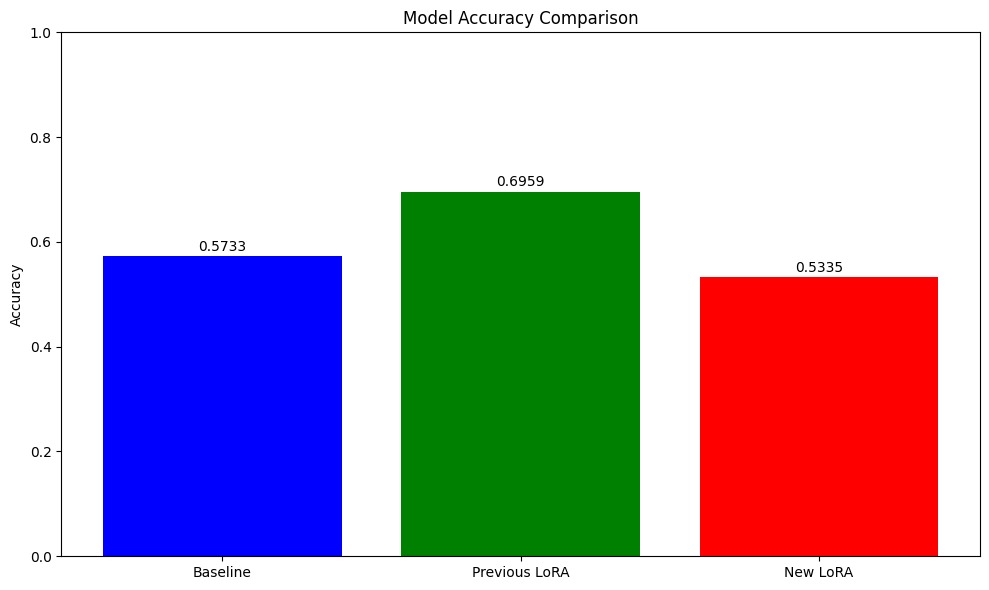

In [20]:
# Load the test data and evaluate the new model
from peft import PeftModel

# Load the baseline model for comparison
baseline_model = AutoModelForVisualQuestionAnswering.from_pretrained(MODEL_NAME)
baseline_model.to(DEVICE)

# Load original LoRA model for comparison
previous_lora_model = AutoModelForVisualQuestionAnswering.from_pretrained(MODEL_NAME)
previous_lora_model = PeftModel.from_pretrained(previous_lora_model, PREVIOUS_LORA_PATH)
previous_lora_model.to(DEVICE)

# Load the new fine-tuned model
new_lora_model = AutoModelForVisualQuestionAnswering.from_pretrained(MODEL_NAME)
new_lora_model = PeftModel.from_pretrained(new_lora_model, "continued_fine_tuning/best_model_epoch_1")  # Adjust epoch as needed
new_lora_model.to(DEVICE)

# Evaluation function
def evaluate_model(model, dataloader, device=DEVICE, model_name="Model"):
    model.eval()
    model.to(device)
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {model_name}"):
            # Move everything to device
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
            
            # Generate predictions
            generated_ids = model.generate(
                pixel_values=batch["pixel_values"],
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=MAX_LENGTH
            )
            
            # Decode predictions and ground truth
            generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
            gt_texts = processor.batch_decode(batch["labels"], skip_special_tokens=True)
            
            # Count correct predictions
            for pred, gt in zip(generated_texts, gt_texts):
                pred = pred.strip().lower()
                gt = gt.strip().lower()
                if pred == gt:
                    correct += 1
                total += 1
    
    accuracy = correct / total if total > 0 else 0
    print(f"{model_name} results: {correct}/{total} correct, Accuracy: {accuracy:.4f}")
    return accuracy

# Try to load the original test dataset 
print("Trying to load test dataset from batch4...")
try:
    # This assumes the code structure and variables from the original notebook
    from torch.utils.data import Dataset
    
    class VQADataset(Dataset):
        def __init__(self, qa_data, base_path, batch_name, processor, max_length=32):
            self.qa_data = qa_data
            self.base_path = base_path
            self.batch_name = batch_name
            self.processor = processor
            self.max_length = max_length
            
            # Flatten the dataset structure for one entry per QA pair
            self.examples = []
            for item in qa_data:
                image_path = os.path.join(base_path, batch_name, item['image_filename'])
                for qa_pair in item['qa_pairs']:
                    self.examples.append({
                        'image_path': image_path,
                        'question': qa_pair['question'],
                        'answer': qa_pair['answer'],
                    })
            
            print(f"Created dataset with {len(self.examples)} examples from {self.batch_name}")
        
        def __len__(self):
            return len(self.examples)
        
        def __getitem__(self, idx):
            example = self.examples[idx]
            
            try:
                image = Image.open(example['image_path']).convert('RGB')
                
                # Process the input (image + question)
                inputs = self.processor(
                    images=image, 
                    text=example['question'], 
                    return_tensors="pt",
                    padding="max_length",
                    max_length=self.max_length,
                    truncation=True
                )
                
                # Remove batch dimension
                for k, v in inputs.items():
                    inputs[k] = v.squeeze(0)
                
                # Process the target (answer)
                target = self.processor.tokenizer(
                    example['answer'],
                    padding="max_length",
                    max_length=self.max_length,
                    truncation=True,
                    return_tensors="pt"
                )
                
                inputs["labels"] = target["input_ids"].squeeze(0)
                
                return inputs
                
            except Exception as e:
                print(f"Error processing {example['image_path']}: {e}")
                # Return a placeholder in case of error
                return self[0] if idx != 0 else None
    
    # Load batch4 data 
    base_path = '/kaggle/working/new_batches'
    with open(os.path.join(base_path, 'batch4_qa_dataset.json'), 'r') as f:
        batch4_data = json.load(f)
    
    # Create evaluation dataset from batch4
    eval_dataset = VQADataset(
        qa_data=batch4_data,
        base_path=base_path,
        batch_name="batch4",
        processor=processor,
        max_length=MAX_LENGTH
    )
    
    # Create DataLoader
    eval_dataloader = DataLoader(
        eval_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )
    
    print(f"Evaluation dataset size: {len(eval_dataset)}")
    
    # Evaluate all three models
    print("\n=== Evaluating Baseline BLIP-VQA Model ===")
    baseline_accuracy = evaluate_model(baseline_model, eval_dataloader, model_name="Baseline")
    
    print("\n=== Evaluating Previous LoRA Fine-tuned Model ===")
    previous_lora_accuracy = evaluate_model(previous_lora_model, eval_dataloader, model_name="Previous LoRA")
    
    print("\n=== Evaluating New LoRA Fine-tuned Model ===")
    new_lora_accuracy = evaluate_model(new_lora_model, eval_dataloader, model_name="New LoRA")
    
    # Compare results
    print("\n=== Model Comparison ===")
    print(f"Baseline model accuracy: {baseline_accuracy:.4f}")
    print(f"Previous LoRA model accuracy: {previous_lora_accuracy:.4f}")
    print(f"New LoRA model accuracy: {new_lora_accuracy:.4f}")
    
    print(f"Improvement (baseline → new): {(new_lora_accuracy - baseline_accuracy)*100:.2f}%")
    print(f"Improvement (previous → new): {(new_lora_accuracy - previous_lora_accuracy)*100:.2f}%")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    models = ['Baseline', 'Previous LoRA', 'New LoRA']
    accuracies = [baseline_accuracy, previous_lora_accuracy, new_lora_accuracy]
    plt.bar(models, accuracies, color=['blue', 'green', 'red'])
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1.0)
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()
    
except Exception as e:
    print(f"Could not evaluate on original test data: {e}")
    print("Please run the evaluation separately after training is complete.")